## Loan Default Prediction using Machine Learning Algorithms

### Problem Statement
The problem is to predict the probability of a loan default. The dataset contains information about the loan and the borrower. The dataset is highly imbalanced with the majority of the loans being non-default. The goal is to predict the probability of a loan default.

In [9]:
# necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb

import git 

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = (13,8)
%config InlineBackend.figure_format = 'retina'

### 1. Load the data and EDA

In [3]:
repoPath = git.Repo('.', search_parent_directories=True)

dataPath = f"{repoPath.working_tree_dir}/data/loan_default/Loan_default.csv"

In [5]:
# load the data
df = pd.read_csv(dataPath)
print("Shape of the data: ", df.shape)
df.head()

Shape of the data:  (255347, 18)


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [7]:
# check if there are any null values
#print(df.isnull().sum())
# check if there are any missing values
#print(df.isna().sum())

There is no missing or null values in the dataset. So, we don't need to do any data cleaning. However, we can just drop "LoandID" column as it doesn't contribute to the prediction. Furthermore, we need to convert categorical columns to numerical columns. We can use one-hot encoding for this purpose.

#### 1.1 Default likelihood by education level

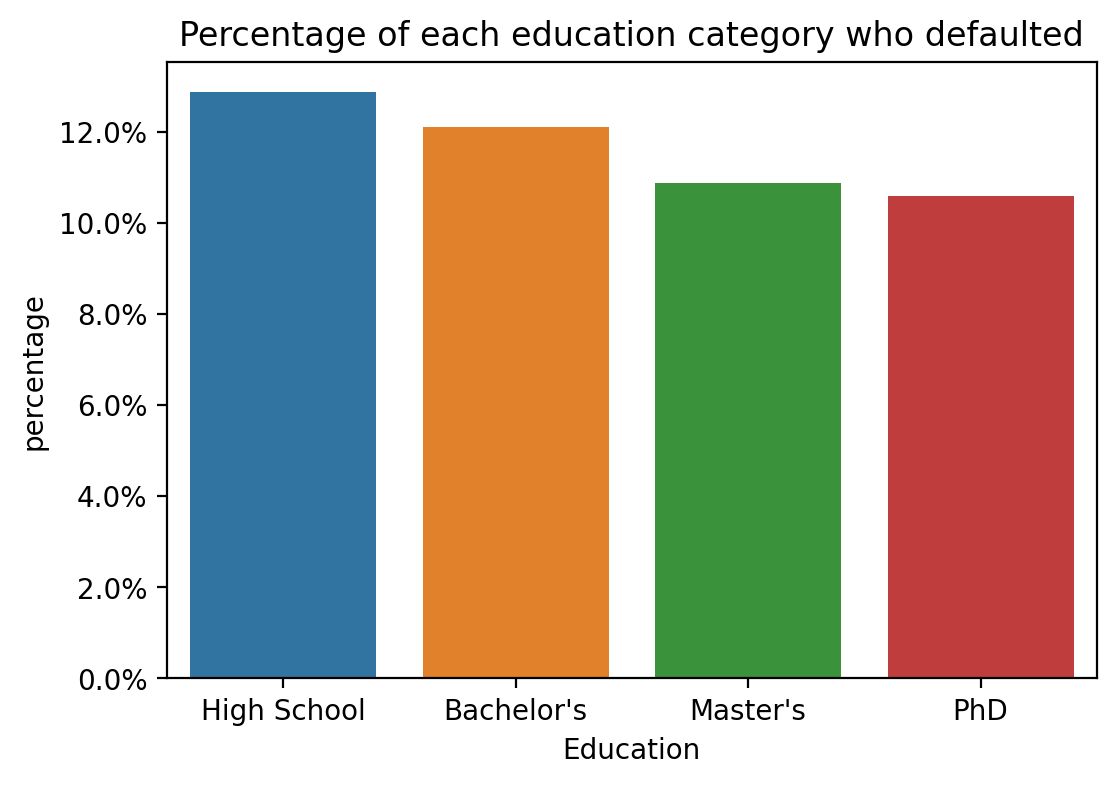

In [11]:
# find percentage of each education category who defaulted
df_education = df.groupby(['Education', 'Default'])['Default'].count().reset_index(name='count').sort_values(['Education', 'Default'], ascending=False)
df_education['percentage'] = df_education['count'].div(df_education.groupby('Education')['count'].transform('sum')).mul(100)
df_education_default = df_education[df_education['Default'] == 1]
df_education_default = df_education_default.sort_values(['percentage'], ascending=False)

# plot the percentage of each education category who defaulted
plt.figure(figsize=(6,4))
sns.barplot(x='Education', y='percentage', data=df_education_default, hue='Education')
# show percentage on y-axis
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Percentage of each education category who defaulted')
plt.show()

#### 1.2 Default likelihood by EmploymentType

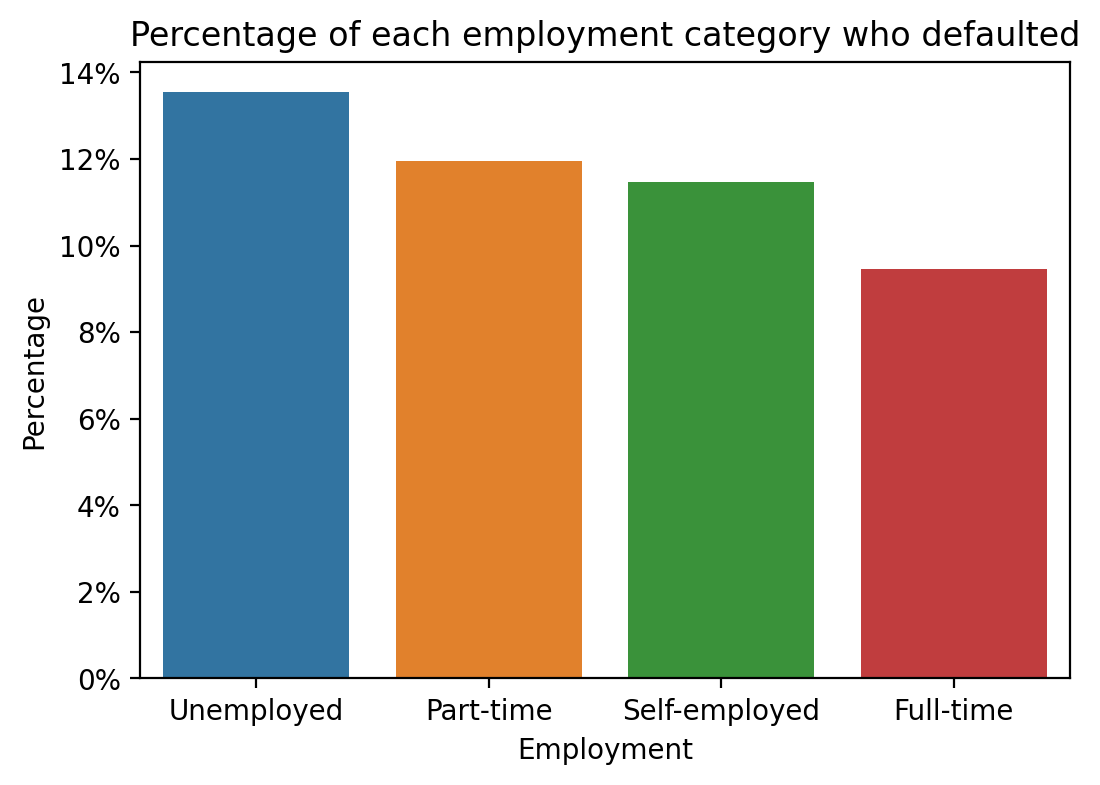

In [8]:
df_emp = df.groupby(['EmploymentType', 'Default'])['Default'].count().reset_index(name='count').sort_values(['EmploymentType', 'Default'], ascending=False)
df_emp['percentage'] = df_emp['count'].div(df_emp.groupby('EmploymentType')['count'].transform('sum')).mul(100)
df_emp_default = df_emp[df_emp['Default'] == 1]
df_emp_default = df_emp_default.sort_values(['percentage'], ascending=False)

# plot the percentage of each employment category who defaulted
plt.figure(figsize=(6,4))
sns.barplot(x='EmploymentType', y='percentage', data=df_emp_default, hue='EmploymentType')
plt.title('Percentage of each employment category who defaulted')
plt.xlabel('Employment')
plt.ylabel('Percentage')

# format y-axis as percentage
fmt = '%.0f%%' # specify the format as percentage with 0 decimal places
yticks = mtick.FormatStrFormatter(fmt)
plt.gca().yaxis.set_major_formatter(yticks)

plt.show()

### 2. Encoding categorical columns and Coorelation

In [5]:
# drop LoanID
df.drop(['LoanID'], axis=1, inplace=True)

In [6]:
# encode the categorical variables
def encode_categorical(df:pd.DataFrame)->pd.DataFrame:
    """
    This function encodes the categorical variables in the dataframe
    """
    le = LabelEncoder()
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = le.fit_transform(df[col])
    return df

In [7]:
df = encode_categorical(df)
df.head()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,56,85994,50587,520,80,4,15.23,36,0.44,0,0,0,1,1,4,1,0
1,69,50432,124440,458,15,1,4.81,60,0.68,2,0,1,0,0,4,1,0
2,46,84208,129188,451,26,3,21.17,24,0.31,2,3,0,1,1,0,0,1
3,32,31713,44799,743,0,3,7.07,24,0.23,1,0,1,0,0,1,0,0
4,60,20437,9139,633,8,4,6.51,48,0.73,0,3,0,0,1,0,0,0


In [8]:
# check the correlation between the target variable and other variables
corr = df.corr()['Default'].sort_values()

In [9]:
corr

Age              -0.167783
Income           -0.099119
MonthsEmployed   -0.097374
HasCoSigner      -0.039109
HasDependents    -0.034678
CreditScore      -0.034166
HasMortgage      -0.022856
Education        -0.022835
LoanPurpose      -0.010096
MaritalStatus    -0.007902
LoanTerm          0.000545
DTIRatio          0.019236
NumCreditLines    0.028330
EmploymentType    0.041010
LoanAmount        0.086659
InterestRate      0.131273
Default           1.000000
Name: Default, dtype: float64

Not all features are strongly correlated to the target column. This means that not every piece of information we have about a loan applicant will directly influence whether they will default on their loan or not. It's important to identify and focus on the features that have the strongest correlation with the target column for the predictive model to be effective.
Let's choose the features that have a correlation of more than 0.05 or less than -0.05 with the target column.

In [10]:
# choose the features with correlation greater than 0.05
features = corr[abs(corr) > 0.05]
df_new = df[features.index]

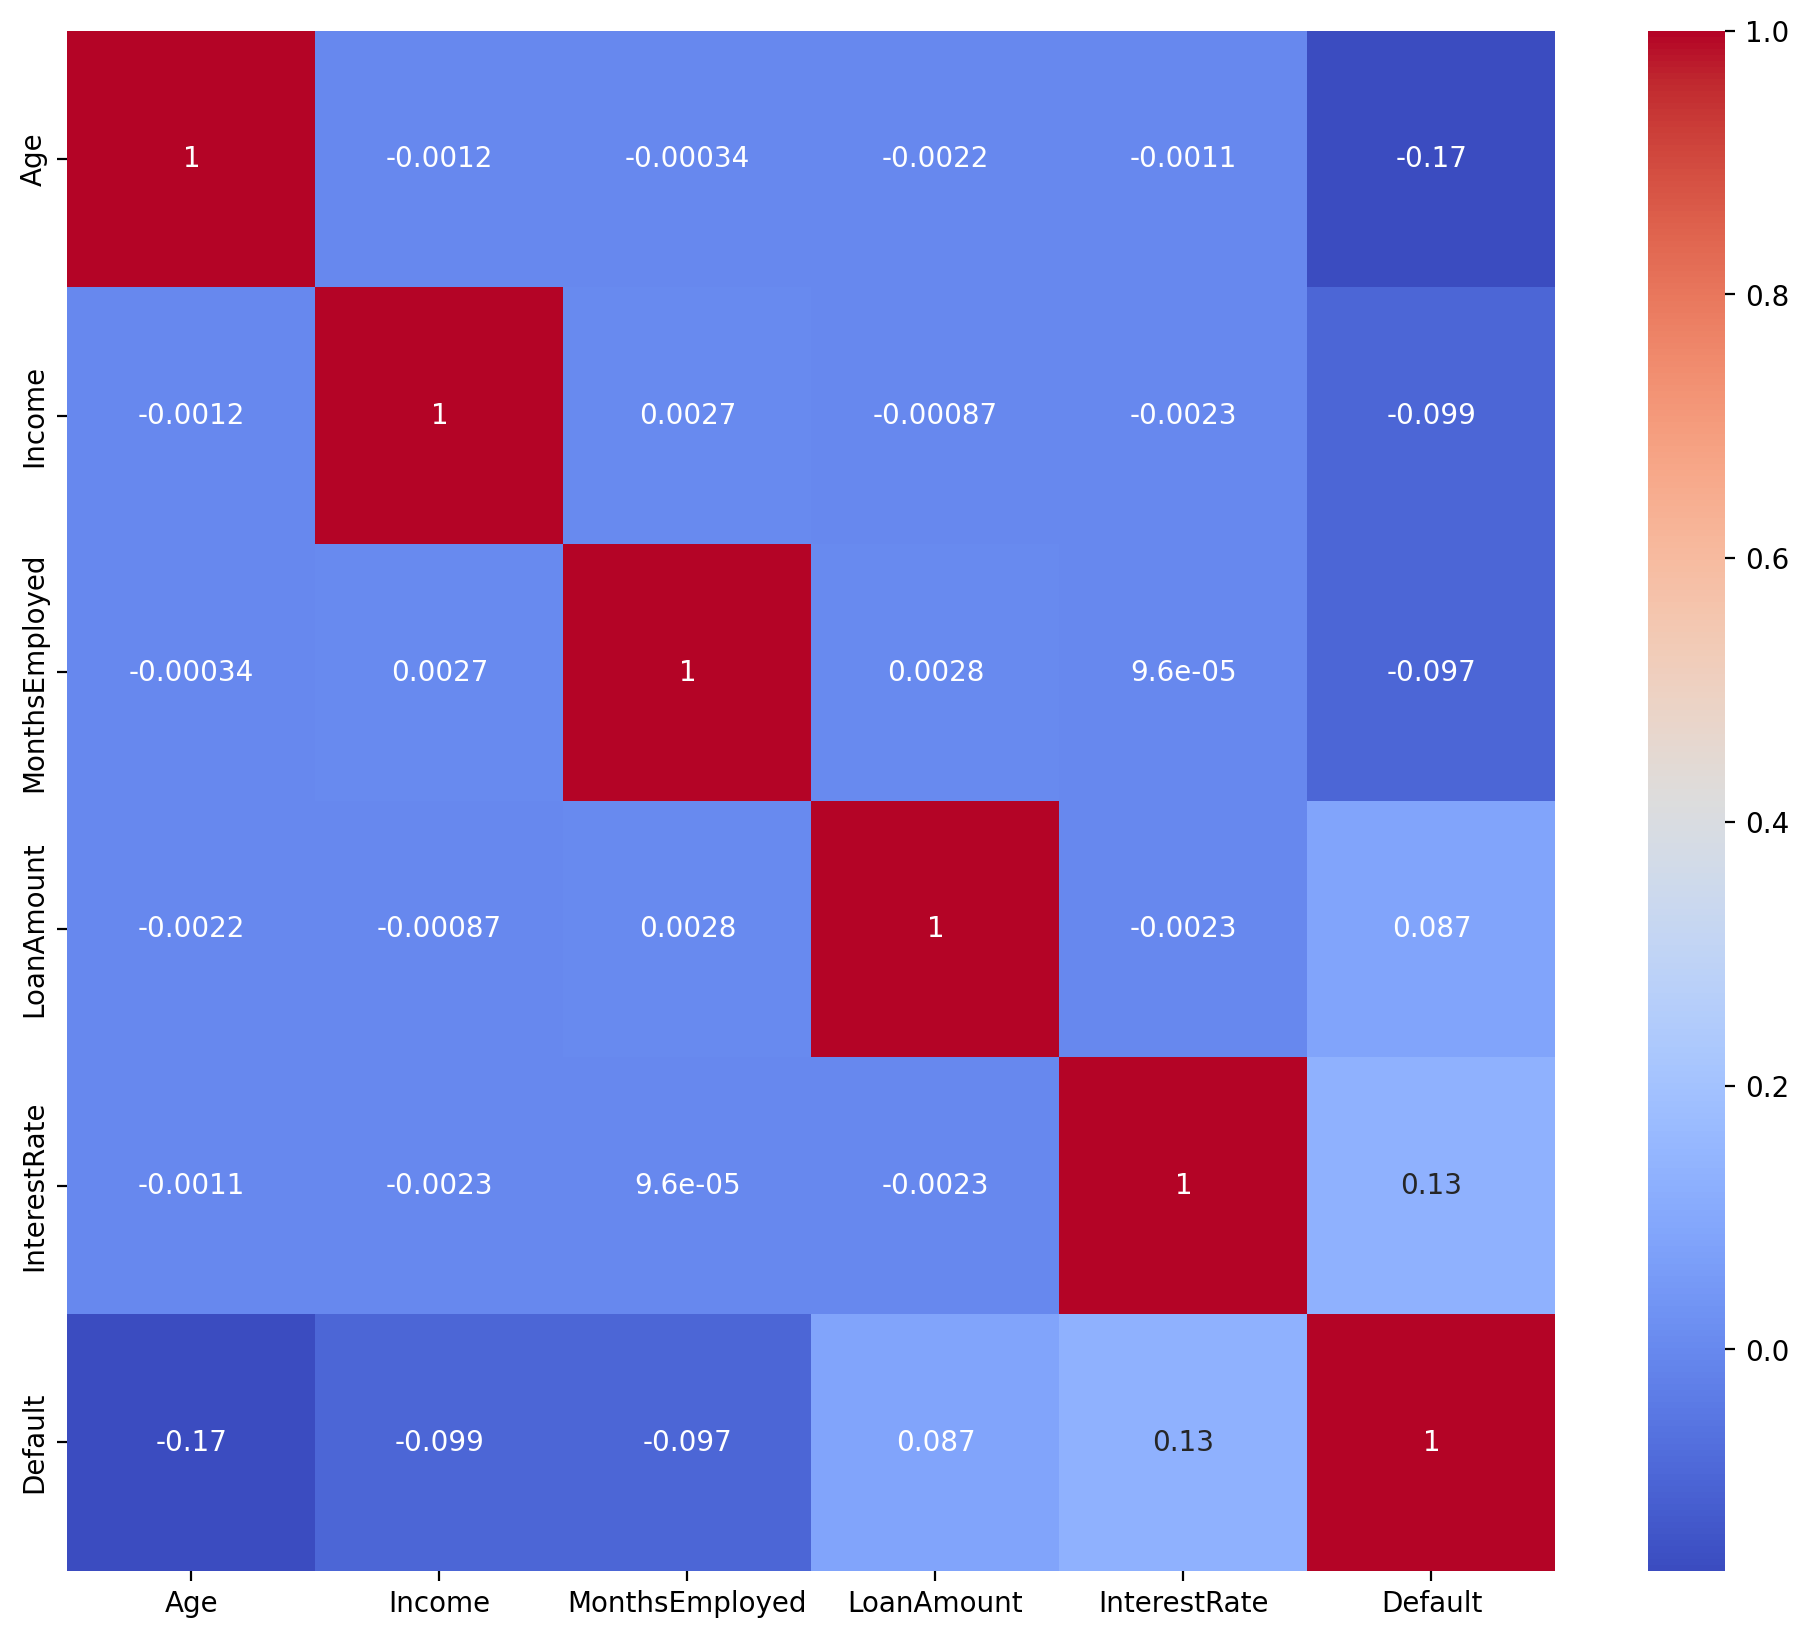

In [11]:
# plot the correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(df_new.corr(), annot=True, cmap='coolwarm')
plt.show()

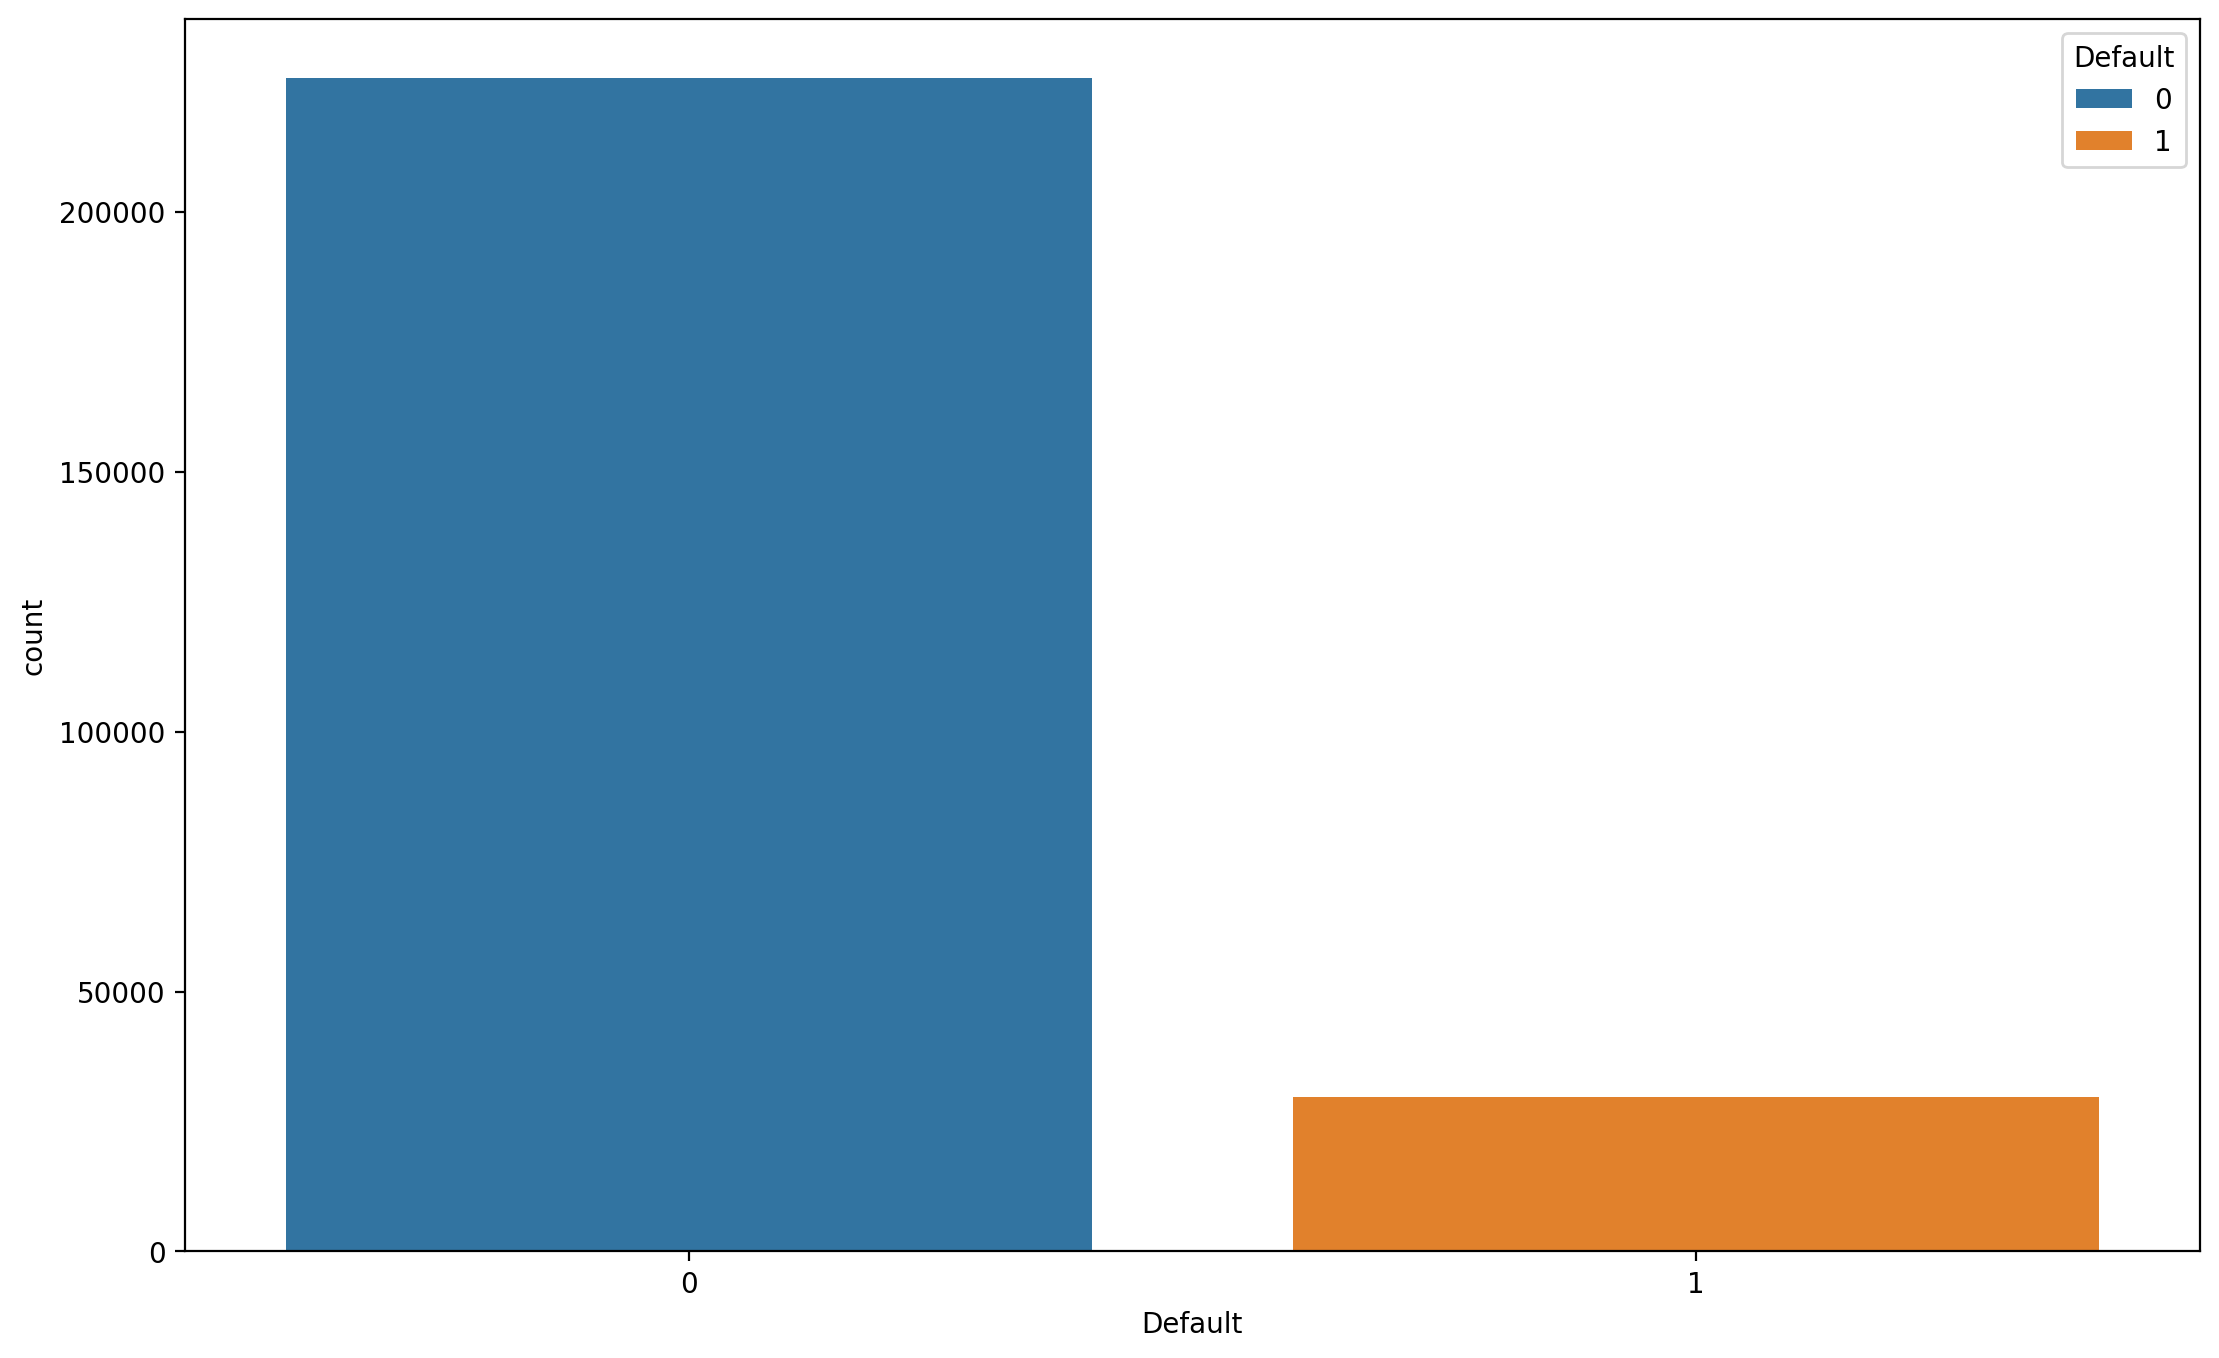

In [12]:
# count plot for the target variable
sns.countplot(x = 'Default', data=df_new, hue='Default')
plt.show()

### 3. Train and Test Split 

In [13]:
# split the data into train and test
# randomly choose 70% of the data for training and 30% for testing
X = df_new.drop(['Default'], axis=1).values
y = df_new['Default'].values
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3, random_state=42)

### 4. Classification Models

In [42]:
# make a classifier function to train and test the model
def xgb_classifier(X:np.array, y:np.array, ratio:float=0.3, random_state:int=42)->None:
    """
    This function trains and tests the XGBoost classifier
    """
    # split the data into train and test
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=ratio, random_state=random_state)

    # create the classifier
    clf = xgb.XGBClassifier()

    # train the classifier
    clf.fit(X_train, y_train)

    # predict the values
    y_pred = clf.predict(X_test)

    accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
    classification_report = sklearn.metrics.classification_report(y_test, y_pred)

    return accuracy, classification_report


In [44]:
# train and test the model
accuracy, classification_report = xgb_classifier(X, y)

print("Accuracy: ", accuracy)

Accuracy:  0.8841720514326741


We got the classification accuracy! Great! But, what does this number really tell us? Let's look at the classification report to see the precision and recall values for each class.

In [45]:
# Classification report
print("Classification report: \n", classification_report)

Classification report: 
               precision    recall  f1-score   support

           0       0.89      0.99      0.94     67681
           1       0.52      0.06      0.11      8924

    accuracy                           0.88     76605
   macro avg       0.71      0.53      0.52     76605
weighted avg       0.85      0.88      0.84     76605



Not very good! We can see that the model is really bad at predicting the minority class. It has a very low precision and recall for the minority class. We need to find a way to improve the model's ability to predict the minority class.

### 5. Dealing with imbalanced classes

In [61]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

#### 5.1 Undersampling
The simplest way to deal with imbalanced classes is to undersample the majority class. We can do this by randomly selecting same number of samples from the majority class as there are in the minority class.

In [56]:
# train test split 
rus = RandomUnderSampler(random_state=42)
X_us, y_us = rus.fit_resample(X, y)

# randomize the data
X_us, y_us = sklearn.utils.shuffle(X_us, y_us, random_state=42)

# train and test the model
accuracy, classification_report = xgb_classifier(X_us, y_us)

print("Accuracy: ", accuracy)
print("Classification report: \n", classification_report)

Accuracy:  0.6645121402877698
Classification report: 
               precision    recall  f1-score   support

           0       0.66      0.67      0.67      8907
           1       0.67      0.66      0.66      8885

    accuracy                           0.66     17792
   macro avg       0.66      0.66      0.66     17792
weighted avg       0.66      0.66      0.66     17792



#### 5.2 Oversampling
Another way to deal with imbalanced classes is to oversample the minority class. We can do this by randomly selecting same number of samples from the minority class as there are in the majority class.

In [57]:
ros = RandomOverSampler(random_state=42)
X_os, y_os = ros.fit_resample(X, y)

# randomize the data
X_os, y_os = sklearn.utils.shuffle(X_os, y_os, random_state=42)

# train and test the model
accuracy, classification_report = xgb_classifier(X_os, y_os)

print("Accuracy: ", accuracy)
print("Classification report: \n", classification_report)

Accuracy:  0.7101693288139599
Classification report: 
               precision    recall  f1-score   support

           0       0.71      0.70      0.71     67777
           1       0.71      0.72      0.71     67640

    accuracy                           0.71    135417
   macro avg       0.71      0.71      0.71    135417
weighted avg       0.71      0.71      0.71    135417



#### 5.3 SMOTE
SMOTE stands for Synthetic Minority Oversampling Technique. Unlike random oversampling, SMOTE does not create exact copies of observations from the minority class. Instead, SMOTE creates new, synthetic, samples that are quite similar to the existing observations in the minority class.

In [58]:
# SMOTE
smk = SMOTETomek(random_state=42)
X_smk, y_smk = smk.fit_resample(X, y)

# randomize the data
X_smk, y_smk = sklearn.utils.shuffle(X_smk, y_smk, random_state=42)

# train and test the model
accuracy, classification_report = xgb_classifier(X_smk, y_smk)

print("Accuracy: ", accuracy)
print("Classification report: \n", classification_report)

Accuracy:  0.8650752937282806
Classification report: 
               precision    recall  f1-score   support

           0       0.82      0.94      0.87     60603
           1       0.93      0.79      0.85     60257

    accuracy                           0.87    120860
   macro avg       0.87      0.86      0.86    120860
weighted avg       0.87      0.87      0.86    120860



#### 5.4 Balanced Bagging Classifier

In [64]:
# Balanced Bagging Classifier
clf = BalancedBaggingClassifier(base_estimator=XGBClassifier(), sampling_strategy='auto', replacement=False, random_state=42)

# fit the classifier
clf.fit(X_train, y_train)

# predict the values
y_pred = clf.predict(X_test)

accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
classification_report = sklearn.metrics.classification_report(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Classification report: \n", classification_report)


Accuracy:  0.6658610611510791
Classification report: 
               precision    recall  f1-score   support

           0       0.67      0.67      0.67      8896
           1       0.67      0.67      0.67      8896

    accuracy                           0.67     17792
   macro avg       0.67      0.67      0.67     17792
weighted avg       0.67      0.67      0.67     17792

